#Подготовка к кластеризации

In [40]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 
from google.colab import files
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import f1_score

In [2]:
KABACHOK = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c urfuengaiml2022clustering
!unzip urfuengaiml2022clustering.zip
!rm /content/urfuengaiml2022clustering.zip

  0% 0.00/953k [00:00<?, ?B/s]
100% 953k/953k [00:00<00:00, 89.2MB/s]
Archive:  urfuengaiml2022clustering.zip
  inflating: Data.csv                
  inflating: Submission.csv          


In [4]:
data = pd.read_csv(
    '/content/Data.csv', 
    delimiter = ',', 
    index_col = 0
)

submission = pd.read_csv(
    '/content/Submission.csv',
    delimiter = ',',
    index_col = 0
)

In [5]:
data

,Признак 1,Признак 2,Признак 3,Признак 4,Признак 5
idx,,,,,
0,-0.179369,-0.013356,0.016641,-0.325923,-0.031094
1,-0.157893,-0.010647,0.002895,-0.332016,-0.012547
2,-0.249451,-0.011700,-0.001435,-0.487909,-0.005343
3,-0.158938,0.210980,0.021905,-0.334196,-0.013976
4,-0.687836,0.422630,0.054028,0.719132,-0.038392
...,...,...,...,...,...
19915,-0.600084,-0.011454,-0.024991,0.700872,0.018778
19916,-0.081612,-0.001023,-0.045937,-0.353670,0.053334
19917,-0.028544,0.002083,-0.048065,-0.493040,0.062817


In [42]:
submission

,label
idx,
0,2
1,0
2,0
3,0
4,1
...,...
19915,0
19916,0
19917,0


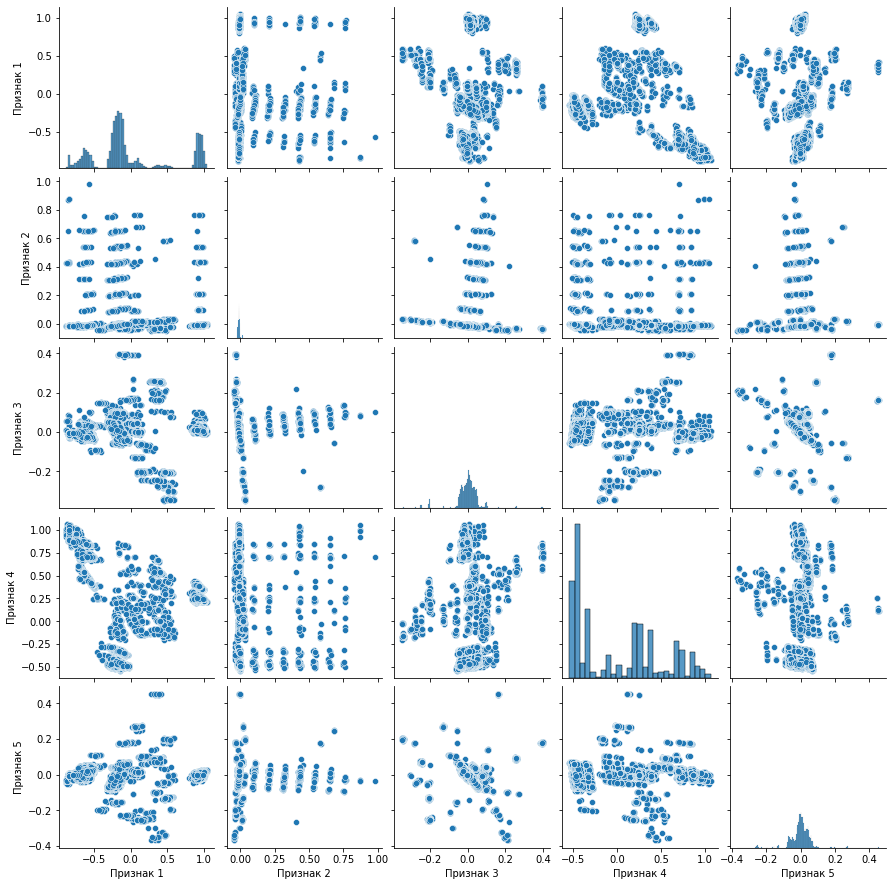

In [6]:
sb.pairplot(data)

In [7]:
col1 = data['Признак 1']
col2 = data['Признак 2']
col3 = data['Признак 3']
col4 = data['Признак 4']
col5 = data['Признак 5']

## За кадром переберём колонки и посмотрим, какое количество кластеров подойдёт лучше :)

Более кучным сочетанием признаков является 1-4, так что оставим их.

In [19]:
df = pd.DataFrame()
df['x'] = col1
df['y'] = col4

df

,x,y
idx,,
0,-0.179369,-0.325923
1,-0.157893,-0.332016
2,-0.249451,-0.487909
3,-0.158938,-0.334196
4,-0.687836,0.719132
...,...,...
19915,-0.600084,0.700872
19916,-0.081612,-0.353670
19917,-0.028544,-0.493040


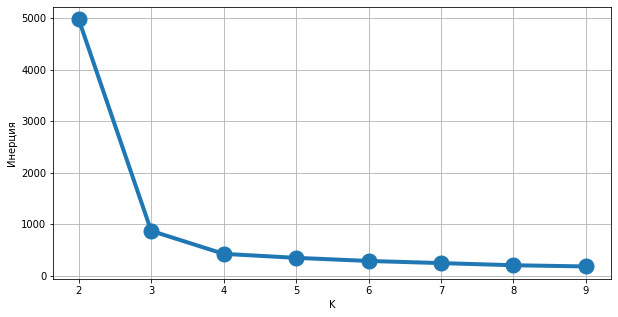

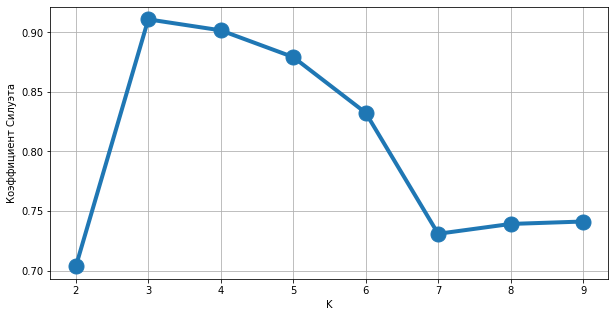

In [43]:
sse = []
sil_scor = []
list_k = list(range(2, 10))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df)
    sse.append(km.inertia_)
    labels = km.fit_predict(df)
    sil_scor.append(metrics.silhouette_score(df, labels, metric='sqeuclidean'))

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',linewidth=4, markersize=15)
plt.grid()
plt.xlabel('K')
plt.ylabel('Инерция');
plt.figure(figsize=(10, 5))
plt.plot(list_k, sil_scor, '-o',linewidth=4, markersize=15)
plt.grid()
plt.xlabel('K')
plt.ylabel('Коэффициент Силуэта');

Опытным путём было получены следующие выводы:
- Колонки 1 и 4 подходят лучше всего (точки расположены более кучно);
- Количество кластеров = 3 (не смотря на то, что в Rules был совет "больше чем три, но меньше чем пять", хотелось бы узнать, почему так)

Именно на этих колонках и будем обучать модель.

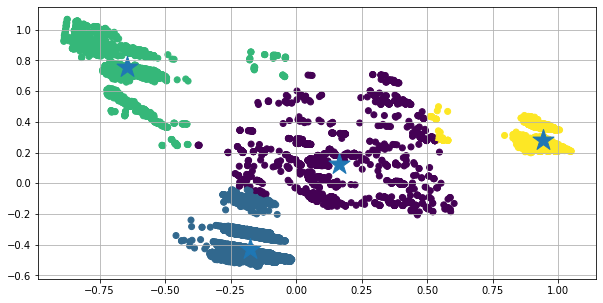

In [44]:
km = KMeans(n_clusters=4)
km.fit(df)
centroids = km.cluster_centers_
labels = km.fit_predict(df)
label_centroids = km.fit_predict(centroids)

df = np.array(df)

plt.figure(figsize=(10, 5))
plt.scatter(df[:, 0], df[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=490)
plt.grid();

#Присвоим правильный порядок кластерам:

In [114]:
indexes = data.index

Submission = pd.DataFrame()
Submission['label'] = labels
Submission.index = indexes
Submission

,label
idx,
0,1
1,1
2,1
3,1
4,2
...,...
19915,2
19916,1
19917,1


In [115]:
Submission.label.value_counts()

1    9576
3    3917
2    3599
0    1941
Name: label, dtype: int64

In [116]:
Submission.label = Submission.label.map({1:0, 0:3, 3:1, 2:2})
Submission.label.value_counts()

0    9576
1    3917
2    3599
3    1941
Name: label, dtype: int64

#Отправляем в кагл

In [117]:
Submission.to_csv('/content/Submission.csv',index=True)

In [118]:
!kaggle competitions submit -c urfuengaiml2022clustering -f Submission.csv -m "Кабачок"

100% 138k/138k [00:03<00:00, 39.5kB/s]
Successfully submitted to UrFU_EngAI_ML_2022_Clustering